In [1]:
#pip install --upgrade "protobuf<=3.20.1"

In [2]:
#necessary imports
import librosa
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import glob,os
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import random

2023-07-25 18:22:08.858092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 18:22:11.605446: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 18:22:11.607622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 18:22:16.521655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
random.seed(1)

In [4]:
# Extracting features from each .wav file
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [5]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)


In [6]:
#Emotions in the dataset
emotions={
  '01':'neutral',
  #'02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  #'07':'disgust',
  #'08':'surprised'
}

#Emotions to observe
#observed_emotions=['calm', 'happy', 'fearful', 'disgust', 'sad']


In [7]:
emotions2={
    'NEU': 'neutral',
    'HAP': 'happy',
    'SAD': 'sad',
    'ANG': 'angry',
    'FEA': 'fearful',
}

In [8]:
def get_features(path, isTraining):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    #data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    data, sample_rate = librosa.load(path, duration=2, offset=0.6, sr=8025)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # Augmenting only training data and skipping augmentation for test data
    if isTraining:
        
        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data, sample_rate)
        result = np.vstack((result, res2)) # stacking vertically

        # data with stretching 
        stretched_data = stretch(data)
        res3 = extract_features(stretched_data, sample_rate)
        result = np.vstack((result, res3)) # stacking vertically
        
        # data with pitch offset
        data_pitch = pitch(data, sample_rate)
        res4 = extract_features(data_pitch, sample_rate)
        result = np.vstack((result, res4)) # stacking vertically
    
    return result

# New Data
## Crema-D dataset

In [9]:
Creama = "data2/"
creama_directory_list = os.listdir(Creama)

file_emotion = []
file_path = []
for file in glob.glob(f"{Creama}*"):
    part = file.split('.')[0]
    part = part.split('_')
    if part[2] not in emotions2.keys():
        continue
    file_emotion.append(part[2])
    file_path.append(file)

# dataframe for emotion of files
emotion2_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files
path2_df = pd.DataFrame(file_path, columns=['Path'])
Creama_df = pd.concat([emotion2_df, path2_df], axis=1)

# Mapping integers to corresponding emotions
Creama_df = Creama_df.replace({'Emotions': emotions2})
print(Creama_df["Emotions"].unique())


['fearful' 'angry' 'sad' 'neutral' 'happy']


In [10]:
# Creating Dataframes
Ravdess = "data/"
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

for folder in glob.glob(f"{Ravdess}Actor_*"):
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(folder)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        if part[2] not in emotions.keys():
            continue
        file_emotion.append(int(part[2]))
        file_path.append(folder + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Mapping integers to corresponding emotions
Ravdess_df.Emotions.replace({1:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear'}, inplace=True)
# ? """Ravdess_df.head()"""

data = pd.concat([Creama_df, Ravdess_df], axis=0)

X = data["Path"]
Y = data["Emotions"]

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, shuffle=True)

In [12]:
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))

(5276,)
(5276,)
(1759,)
(1759,)


In [13]:
X, Y = [], []
for path, emotion in zip(X_train, Y_train):
    feature = get_features(path, True)
    for ele in feature:
        X.append(ele)
        # appending emotion 4 times as we have applied 4 augmentation techniques on each audio file
        Y.append(emotion)
x_train = X
y_train = Y

/home/codespace/.python/current/lib/python3.10/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [14]:
# Saving features in a csv file to avoid redundant feature extraction
Features = pd.DataFrame(x_train)
Features['labels'] = y_train
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.132812,0.786461,0.788402,0.502173,0.456299,0.488599,0.458573,0.497425,0.589869,0.639345,...,0.106477,0.037218,0.030323,0.022959,0.034632,0.018931,0.007288,0.001811,0.000043,angry
1,0.197499,0.794354,0.684380,0.456011,0.470637,0.497837,0.486151,0.527306,0.641404,0.627995,...,0.105259,0.037137,0.030578,0.023704,0.035130,0.019389,0.007926,0.002445,0.000779,angry
2,0.155408,0.906215,0.619200,0.418835,0.486907,0.462776,0.463361,0.517800,0.655547,0.588477,...,0.066172,0.022858,0.017371,0.012629,0.020867,0.012879,0.005110,0.001129,0.000024,angry
3,0.161833,0.527145,0.869874,0.795607,0.476046,0.447058,0.478203,0.410140,0.459286,0.580427,...,0.083353,0.028837,0.070650,0.033715,0.023035,0.016411,0.013157,0.004276,0.000025,angry
4,0.123682,0.609155,0.439890,0.468290,0.535586,0.620048,0.572363,0.580419,0.533955,0.571267,...,0.033259,0.025641,0.091899,0.020896,0.011710,0.024206,0.016897,0.003146,0.000130,angry


In [15]:
x_train = Features.iloc[: ,:-1].values
y_train = Features['labels'].values
print(y_train)

['angry' 'angry' 'angry' ... 'fearful' 'fearful' 'fearful']


In [16]:
encoder = sklearn.preprocessing.OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
print(y_train)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [17]:
X, Y = [], []
for path, emotion in zip(X_test, Y_test):
    feature = get_features(path, False)   
    X.append(feature)
    Y.append(emotion)

print(np.shape(X))
print(np.shape(Y))
x_test = np.array(X)
y_test = np.array(Y)


(1759, 162)
(1759,)


In [18]:
Y_test.head(5)

4003      happy
474         sad
3927        sad
4694    fearful
1237    fearful
Name: Emotions, dtype: object

In [19]:
X_test.head(5)

4003                 data2/1048_IEO_HAP_MD.wav
474     data/Actor_09/03-01-04-02-01-02-09.wav
3927                 data2/1038_TSI_SAD_XX.wav
4694                 data2/1024_TIE_FEA_XX.wav
1237                 data2/1044_TSI_FEA_XX.wav
Name: Path, dtype: object

In [20]:
encoder = sklearn.preprocessing.OneHotEncoder()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [21]:
# Normalization
scaler = sklearn.preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21104, 162), (21104, 6), (1759, 162), (1759, 6))

In [22]:
model1=MLPClassifier(alpha=0.01, batch_size=64, epsilon=1e-08, hidden_layer_sizes=(500,), learning_rate='adaptive', max_iter=500)
model1.fit(x_train,y_train)
score = model1.score(x_test, y_test)
print("Accuracy:", score)

Accuracy: 0.4019329164297897


In [23]:
# Reshaping train and test data for new model
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21104, 162, 1), (21104, 6), (1759, 162, 1), (1759, 6))

# old model
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

In [24]:
model = Sequential()
model.add(Conv1D(32, 8, padding='same',activation='relu', input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
# model.add(Conv1D(32, 8, padding='same', activation='relu'))
model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.45))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(256, 8, padding='same',activation='relu'))
model.add(Conv1D(256, 8, padding='same',activation='relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1],activation='softmax')) # Target class number
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()
# model = Sequential()
# model.add(Conv1D(256, 8, padding='same',activation='relu', input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
# model.add(Conv1D(256, 8, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 8, padding='same', activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(64, 8, padding='same',activation='relu'))
# model.add(Conv1D(64, 8, padding='same',activation='relu'))
# model.add(Flatten())
# model.add(Dense(y_train.shape[1],activation='softmax')) # Target class number
# model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          2304      
                                                                 
 conv1d_1 (Conv1D)           (None, 162, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 162, 256)         1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 162, 256)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 256)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 128)           2

In [25]:
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
history=model.fit(x_train, y_train, batch_size=32, epochs=65, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/70
 15/330 [>.............................] - ETA: 2:13 - loss: 1.7166 - accuracy: 0.2750

330/330 [==============================] - 120s 351ms/step - loss: 1.4479 - accuracy: 0.3927 - val_loss: 2.6954 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 2/70
330/330 [==============================] - 113s 344ms/step - loss: 1.3004 - accuracy: 0.4423 - val_loss: 1.5524 - val_accuracy: 0.4213 - lr: 0.0010
Epoch 3/70
330/330 [==============================] - 107s 324ms/step - loss: 1.2319 - accuracy: 0.4748 - val_loss: 1.3132 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 4/70
330/330 [==============================] - 105s 318ms/step - loss: 1.1725 - accuracy: 0.5081 - val_loss: 1.1905 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 5/70
330/330 [==============================] - 106s 320ms/step - loss: 1.1218 - accuracy: 0.5313 - val_loss: 1.2475 - val_accuracy: 0.4798 - lr: 0.0010
Epoch 6/70
330/330 [==============================] - 107s 322ms/step - loss: 1.0739 - accuracy: 0.5584 - val_loss: 1.1657 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 7/70
330/330 [==============================] - 105

In [26]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")

 1/55 [..............................] - ETA: 2s - loss: 3.4870 - accuracy: 0.7188

55/55 [==============================] - 2s 35ms/step - loss: 5.5696 - accuracy: 0.5372
Accuracy of our model on test data :  53.72370481491089 %


In [27]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)


55/55 [==============================] - 2s 32ms/step


,Predicted Labels,Actual Labels
0,fearful,happy
1,sad,sad
2,sad,sad
3,happy,fearful
4,angry,fearful
5,fearful,fearful
6,neutral,neutral
7,sad,sad
8,sad,sad
9,fearful,angry


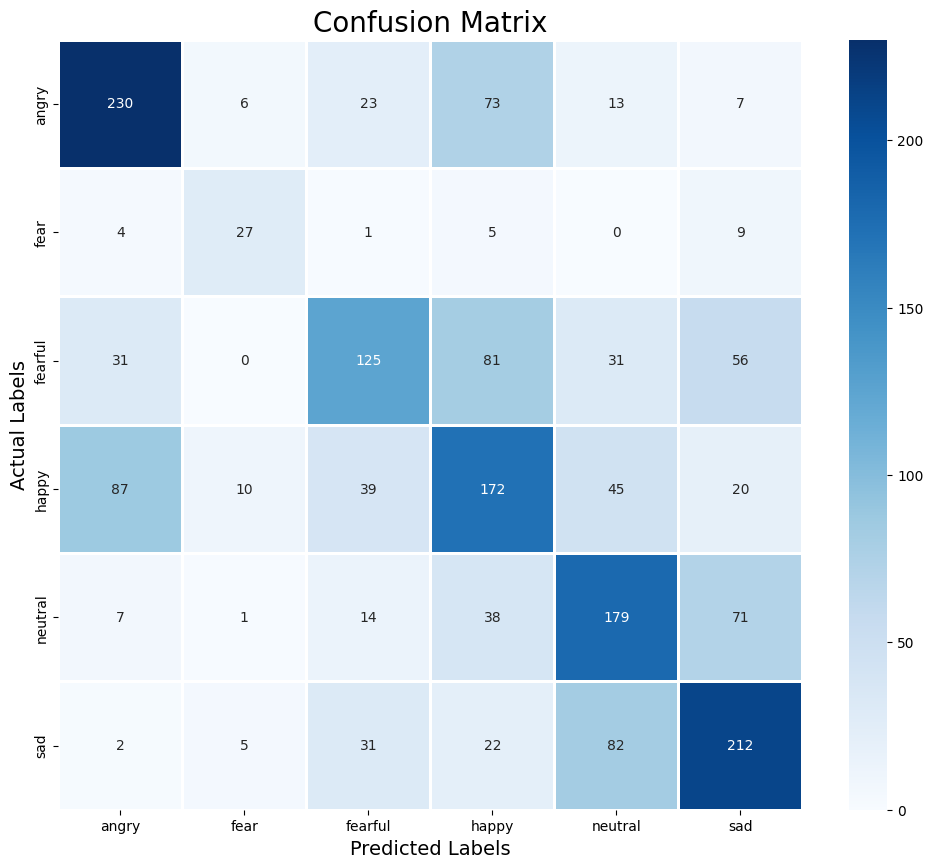

In [28]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [29]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.64      0.65      0.65       352
        fear       0.55      0.59      0.57        46
     fearful       0.54      0.39      0.45       324
       happy       0.44      0.46      0.45       373
     neutral       0.51      0.58      0.54       310
         sad       0.57      0.60      0.58       354

    accuracy                           0.54      1759
   macro avg       0.54      0.54      0.54      1759
weighted avg       0.54      0.54      0.53      1759



In [30]:
# pip install tf2onnx

In [31]:
import tf2onnx
import tensorflow as tf

onnx_model, _ = tf2onnx.convert.from_keras(model)
tf.io.write_graph(onnx_model, '.', 'model.onnx', as_text=False)

2023-07-25 20:52:10.443695: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-07-25 20:52:10.458421: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-07-25 20:52:10.784487: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-07-25 20:52:10.784726: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


'./model.onnx'

In [32]:
# Saved the current model to replicate results
#dump(model, open('model.pkl', 'wb'))

In [33]:
from pickle import dump
dump(scaler, open('scaler.pkl', 'wb'))

In [34]:
dump(encoder, open('encoder.pkl', 'wb'))

In [35]:
input_name = onnx_model.graph.input[0].name
output_name = onnx_model.graph.output[0].name

print("Input node name:", input_name)
print("Output node name:", output_name)

Input node name: conv1d_input
Output node name: dense
